In [2]:
import numpy as np
from scipy.io import arff
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping

In [3]:
data, meta = arff.loadarff('dataSet.arff')
df = pd.DataFrame(data)
df = df.astype(int)
    
X = df.drop('Result', axis=1)
Y = df['Result']

# Y_binary = (Y + 1) // 2
# print(Y_binary[0:5])
# print(Y.head())


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2023)

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)

In [4]:
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=X.shape[1]))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(30, input_shape=(X.shape[1],), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu))

# model.add(tf.keras.layers.Dense(4, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, validation_split=0.2)

Epoch 1/100
222/222 [==============================] - 1s 2ms/step - loss: 0.3968 - accuracy: 0.8113 - val_loss: 0.2092 - val_accuracy: 0.9203
Epoch 2/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1934 - accuracy: 0.9282 - val_loss: 0.1775 - val_accuracy: 0.9276
Epoch 3/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1775 - accuracy: 0.9299 - val_loss: 0.1704 - val_accuracy: 0.9237
Epoch 4/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1698 - accuracy: 0.9333 - val_loss: 0.1667 - val_accuracy: 0.9265
Epoch 5/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1634 - accuracy: 0.9363 - val_loss: 0.1611 - val_accuracy: 0.9322
Epoch 6/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1588 - accuracy: 0.9364 - val_loss: 0.1566 - val_accuracy: 0.9339
Epoch 7/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1529 - accuracy: 0.9402 - val_loss: 0.1535 - val_accuracy: 0.9327

In [5]:
accuracy = model.evaluate(X_test, Y_test)[1]

70/70 [==============================] - 0s 768us/step - loss: 0.1360 - accuracy: 0.9502


In [6]:
def create_model(optimizer='adam', activation='tanh', neurons_layer_one = 30, hidden_neurons = 12, dropout_rate = 0):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons_layer_one, input_shape=(30,), activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(hidden_neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=2)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
optimizer=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation=['softmax', 'relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hidden_neurons=[4, 8, 12, 15]
neurons_layer_one=[15, 20, 25, 30, 40]
#param_grid=dict(model__activation=activation,model__optimizer=optimizer, model__neurons_layer_one=neurons_layer_one, model__hidden_neurons=hidden_neurons)
#param_grid=dict(model__activation=activation, model__dropout_rate=dropout_rate)
param_grid=dict()

cv = 0
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
grid_result = grid.fit(X_train, Y_train, callbacks=[early_stopping], validation_split=0.2, validation_data=(X_test, Y_test), verbose=2)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
885/885 - 1s - loss: 0.2462 - accuracy: 0.9049 - val_loss: 0.1954 - val_accuracy: 0.9236 - 1s/epoch - 2ms/step
Epoch 2/100
885/885 - 1s - loss: 0.1771 - accuracy: 0.9314 - val_loss: 0.1725 - val_accuracy: 0.9245 - 828ms/epoch - 936us/step
Epoch 3/100
885/885 - 1s - loss: 0.1647 - accuracy: 0.9332 - val_loss: 0.1766 - val_accuracy: 0.9267 - 831ms/epoch - 939us/step
Epoch 4/100
885/885 - 1s - loss: 0.1546 - accuracy: 0.9395 - val_loss: 0.1604 - val_accuracy: 0.9353 - 834ms/epoch - 942us/step
Epoch 5/100
885/885 - 1s - loss: 0.1455 - accuracy: 0.9403 - val_loss: 0.1679 - val_accuracy: 0.9308 - 827ms/epoch - 934us/step
Epoch 6/100
885/885 - 1s - loss: 0.1382 - accuracy: 0.9450 - val_loss: 0.1446 - val_accuracy: 0.9385 - 827ms/epoch - 934us/step
Epoch 7/100
885/885 - 1s - loss: 0.1309 - accuracy: 0.9454 - val_loss: 0.1451 - val_accuracy: 0.9371 - 830ms/epoch - 938us/step
Epoch 8/100
885/885 - 1s - loss: 0.1233 - accuracy: 0.9488 - val_loss: 0.1298 - val_accuracy: 0.9475 - 850ms/

In [7]:
best_model = grid.best_estimator_
print(best_model)

KerasClassifier(
	model=<function create_model at 0x000002574D6B1670>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=binary_crossentropy
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)


In [17]:
import MetricFunctions
MetricFunctions.printAccuracy(best_model, X_train, X_test, Y_train, Y_test)
MetricFunctions.printLoss(best_model, X_train, X_test, Y_train, Y_test)

222/222 - 0s - 153ms/epoch - 689us/step
885/885 - 1s - 511ms/epoch - 577us/step
Test accuracy: 95.75%
Train accuracy: 98.84%
222/222 - 0s - 142ms/epoch - 640us/step
Test Log Loss: 0.11268504354561773
885/885 - 1s - 508ms/epoch - 574us/step
Train Log Loss: 0.02728884796092416


In [9]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)
y_score = y_prob[:, 1]

222/222 - 0s - 147ms/epoch - 662us/step
222/222 - 0s - 142ms/epoch - 640us/step


In [10]:
MetricFunctions.printAUCandPvalues(Y_test, y_score)

AUC-ROC: 0.9945647648547828
P-value: 0.010870470290434309


In [11]:
MetricFunctions.printAUCPRandF1Scores(Y_test, y_pred, y_score)

AUC-PR: 0.9958470782003952
F1 Score: 0.9624300559552358


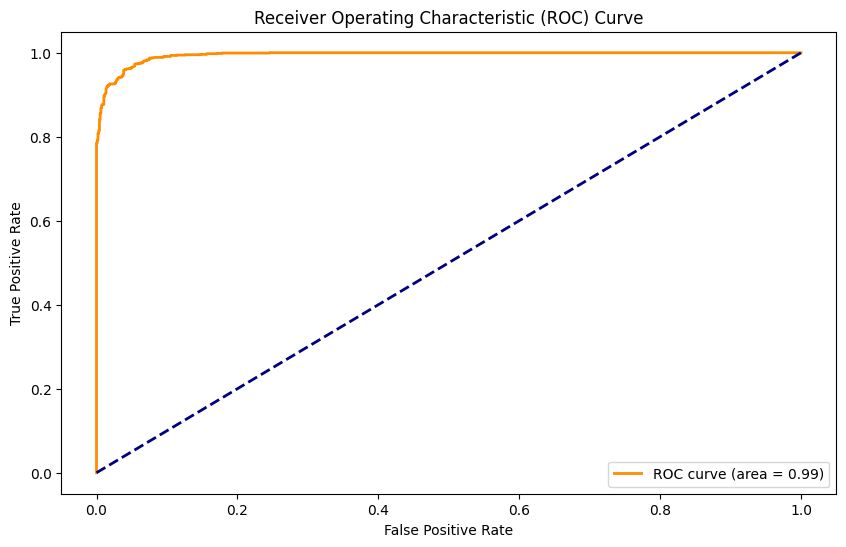

In [12]:
MetricFunctions.plotROCCurve(Y_test, y_score)

222/222 - 0s - 148ms/epoch - 667us/step


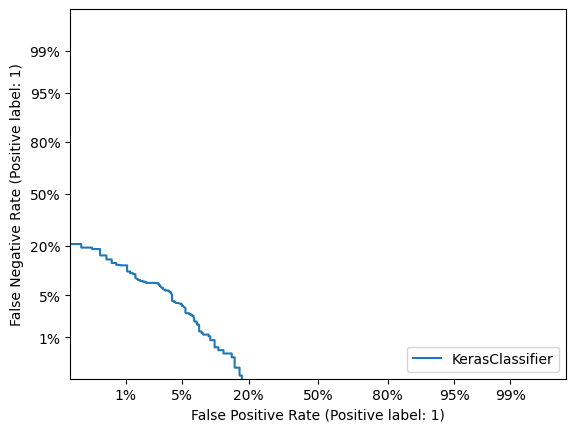

In [13]:
MetricFunctions.plotDetCurve(best_model, X_test, Y_test)

Confusion Matrix:
[[ 913   47]
 [  47 1204]]


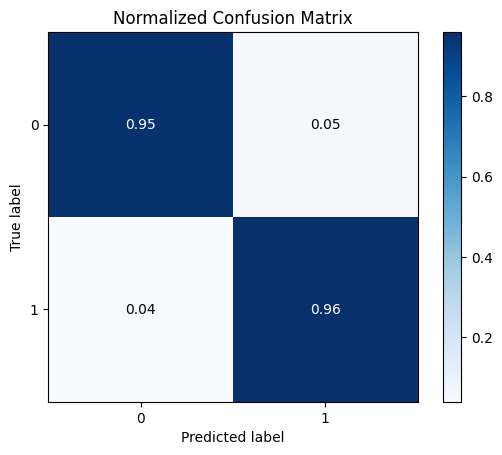

In [14]:
MetricFunctions.printConfMatrix(Y_test, y_pred)
MetricFunctions.plotConfMatrix(Y_test, y_pred)

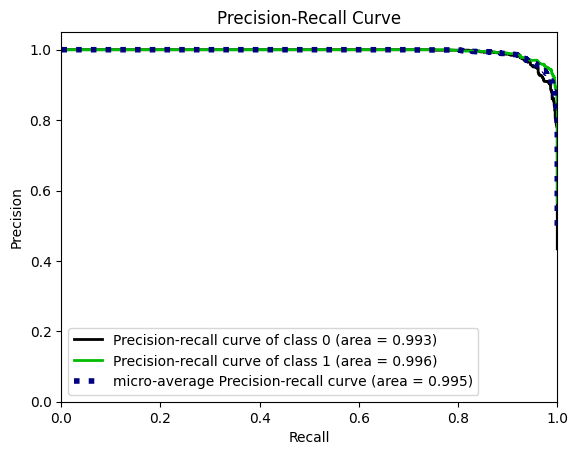

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_precision_recall(Y_test, y_prob)
plt.show()

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

In [46]:
print(X.columns.tolist())

['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [47]:
perm = PermutationImportance(best_model, random_state=2023).fit(X_test,Y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

222/222 - 0s - 139ms/epoch - 626us/step
222/222 - 0s - 138ms/epoch - 622us/step
222/222 - 0s - 137ms/epoch - 617us/step
222/222 - 0s - 149ms/epoch - 671us/step
222/222 - 0s - 143ms/epoch - 644us/step
222/222 - 0s - 170ms/epoch - 766us/step
222/222 - 0s - 143ms/epoch - 644us/step
222/222 - 0s - 151ms/epoch - 680us/step
222/222 - 0s - 152ms/epoch - 685us/step
222/222 - 0s - 149ms/epoch - 671us/step
222/222 - 0s - 139ms/epoch - 626us/step
222/222 - 0s - 138ms/epoch - 622us/step
222/222 - 0s - 139ms/epoch - 626us/step
222/222 - 0s - 137ms/epoch - 617us/step
222/222 - 0s - 139ms/epoch - 626us/step
222/222 - 0s - 141ms/epoch - 635us/step
222/222 - 0s - 139ms/epoch - 626us/step
222/222 - 0s - 138ms/epoch - 622us/step
222/222 - 0s - 140ms/epoch - 631us/step
222/222 - 0s - 140ms/epoch - 631us/step
222/222 - 0s - 138ms/epoch - 622us/step
222/222 - 0s - 141ms/epoch - 635us/step
222/222 - 0s - 141ms/epoch - 635us/step
222/222 - 0s - 141ms/epoch - 635us/step
222/222 - 0s - 140ms/epoch - 631us/step


Weight,Feature
0.1430 ± 0.0085,URL_of_Anchor
0.0975 ± 0.0069,SSLfinal_State
0.0295 ± 0.0062,web_traffic
0.0257 ± 0.0027,Prefix_Suffix
0.0238 ± 0.0034,having_Sub_Domain
0.0213 ± 0.0053,Links_in_tags
0.0185 ± 0.0051,Links_pointing_to_page
0.0161 ± 0.0079,having_IP_Address
0.0138 ± 0.0038,SFH
0.0126 ± 0.0043,DNSRecord


In [16]:
import pickle

model_pkl_file = "nn_model_estimator_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(grid.best_estimator_, file)

INFO:tensorflow:Assets written to: C:\Users\augus\AppData\Local\Temp\tmpyw3qbc6f\assets


INFO:tensorflow:Assets written to: C:\Users\augus\AppData\Local\Temp\tmpyw3qbc6f\assets


C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from ver

INFO:tensorflow:Assets written to: C:\Users\augus\AppData\Local\Temp\tmp3p3idjsi\assets


INFO:tensorflow:Assets written to: C:\Users\augus\AppData\Local\Temp\tmp3p3idjsi\assets


222/222 - 0s - 168ms/epoch - 757us/step


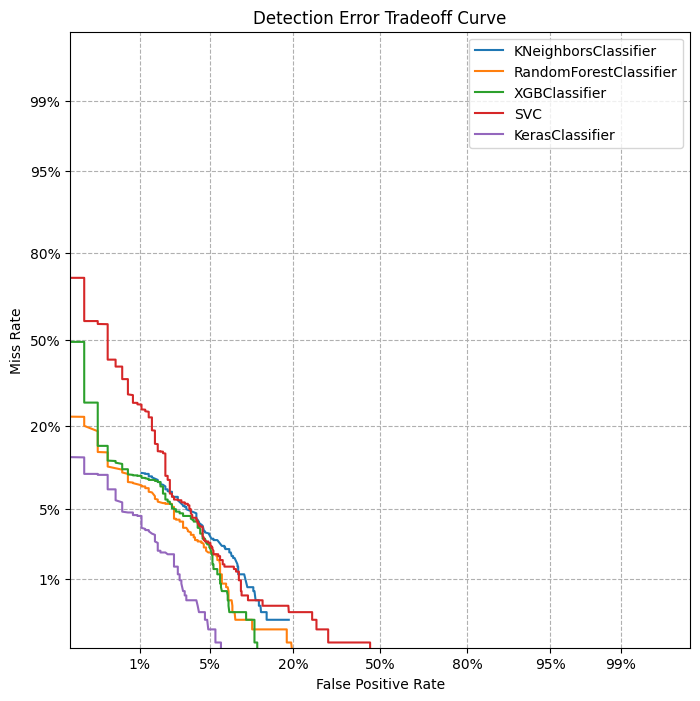

In [18]:
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, DetCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.io import arff
import joblib
import numpy as np
import copy

def plotROCCurve_multi(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        y_score = model.predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_score)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        
        plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} (AUC = {auc_roc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plotPrecisionRecallCurve_multi(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = skplt.metrics.precision_recall_curve(y_test, y_prob)
        plt.plot(recall, precision, lw=2, label=f'{model.__class__.__name__}')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")
    plt.show()

def plotDetCurve_multi(models, X_test, y_test):
    fig, ax_det = plt.subplots(figsize=(8, 8))

    for model in models:
        det_curve_display = DetCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_det, name=str(model))
        model_name = model.__class__.__name__
        det_curve_display.line_.set_label(model_name)

    ax_det.set_xlabel('False Positive Rate')
    ax_det.set_ylabel('Miss Rate')
    ax_det.set_title('Detection Error Tradeoff Curve')
    ax_det.grid(linestyle='--')
    ax_det.legend()

    plt.show()


if __name__ == '__main__':
    knn_model = joblib.load('models/knn_model.pkl')
    rf_model = joblib.load('models/rf_model.pkl')
    xgb_model = joblib.load('models/xgb_model.pkl')
    svm_model = joblib.load('models/svm_model.pkl')
    nn_model = copy.deepcopy(best_model)

    models = [knn_model, rf_model, xgb_model, svm_model, nn_model]

    data, meta = arff.loadarff('dataset.arff')
    df = pd.DataFrame(data)
    for column in df.columns:
        df[column] = df[column].str.decode('utf-8').astype(int)
    X = df.drop('Result', axis=1)
    y = df['Result']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)
    #plotROCCurve_multi(models, X_test, y_test)
    #plotPrecisionRecallCurve_multi(models, X_test, y_test)
    plotDetCurve_multi(models, X_test, y_test)